In [13]:
import zipfile  # For handling zip files
import io  # For input/output operations
import os  # For operating system related operations
import torch  # PyTorch library for deep learning
import pandas as pd  # For data manipulation and analysis
from torch.utils.data import Dataset  # For creating custom datasets
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments  # BERT-related components
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from google.colab import files  # For handling file uploads in Google Colab
from sklearn.metrics import accuracy_score  # For calculating model accuracy

# Upload the zip file
uploaded = files.upload()

# Get the filename of the uploaded file
filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# Create dataset directory if it doesn't exist
os.makedirs('dataset', exist_ok=True)

# Extract the contents of the zip file
zip_file = uploaded[filename]
with zipfile.ZipFile(io.BytesIO(zip_file), 'r') as zip_ref:
    zip_ref.extractall('dataset')

# List all files in the dataset directory
print("\nFiles in dataset directory:")
for file in os.listdir('dataset'):
    print(f"- {file}")

# Find the first CSV file in the directory
csv_files = [f for f in os.listdir('dataset') if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in the extracted contents")

# Use the first CSV file found
data_path = os.path.join('dataset', csv_files[0])
print(f"\nLoading CSV file: {data_path}")

# Read the CSV file
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("\nDataset Information:")
print(f"Number of rows: {len(df)}")
print("Columns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Saving compressed_values (1).zip to compressed_values (1).zip
Uploaded file: compressed_values (1).zip

Files in dataset directory:
- reduced_dataset.csv
- compressed_values.csv

Loading CSV file: dataset/reduced_dataset.csv

Dataset Information:
Number of rows: 25000
Columns: ['Unnamed: 0', 'text', 'class']

First few rows:
   Unnamed: 0                                               text        class
0      111734  I Don't know?7? Months self harm free and the ...      suicide
1      224358  I HAVE TO START BECOMING RICH I HAVE TO START ...  non-suicide
2       18790  A poem (haiku) for u/Me-Game-Dev hi, hello hel...  non-suicide
3       21196  I've honestly got no idea what to do anymore.I...      suicide
4       46089  Do you ever just cry? Like you just think abou...  non-suicide


In [14]:
df = df[['text', 'class']]

# Convert categorical labels to binary values: 'suicide' -> 1, 'non-suicide' -> 0
df['class'] = df['class'].map({'suicide': 1, 'non-suicide': 0})

# Split the data into training and validation sets
train_texts, val_texts, train_classes, val_classes = train_test_split(
    df['text'].tolist(),  # Convert text column to list
    df['class'].tolist(),  # Convert class column to list
    test_size=0.2,
    random_state=42
)

# Initialize the BERT tokenizer with pre-trained weights
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

# Create a custom Dataset class for the suicide detection task
class SuicideDetectionDataset(Dataset):
    def __init__(self, encodings, classes):
        self.encodings = encodings  # Store tokenized texts
        self.classes = classes  # Store corresponding labels

    def __len__(self):
        return len(self.classes)  # Return number of samples

    def __getitem__(self, idx):
        # Convert encodings to PyTorch tensors for a given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label as a tensor
        item['labels'] = torch.tensor(self.classes[idx])
        return item

# Create training and validation datasets using the custom Dataset class
train_dataset = SuicideDetectionDataset(train_encodings, train_classes)
val_dataset = SuicideDetectionDataset(val_encodings, val_classes)

<ipython-input-14-64e0eee6022f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class'].map({'suicide': 1, 'non-suicide': 0})


In [15]:
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Initialize BERT model for binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Define training arguments/hyperparameters
training_args = TrainingArguments(
    output_dir='./results',  # Directory to save model checkpoints
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=8,  # Training batch size per device
    per_device_eval_batch_size=8,  # Evaluation batch size per device
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="steps",  # When to perform evaluation
    eval_steps=100,  # Evaluate every 100 steps
    save_strategy="steps",  # When to save model checkpoints
    save_steps=100,  # Save model every 100 steps
    save_total_limit=3,  # Maximum number of checkpoints to keep
    report_to=None  # Disable external reporting
)

# Define function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Convert logits to predictions
    return {"eval_accuracy": accuracy_score(labels, predictions)}

# Initialize the trainer
trainer = Trainer(
    model=model,  # The pretrained model
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    compute_metrics=compute_metrics  # Metrics computation function
)

# Start the training process
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss,Accuracy
100,0.447400,0.387779,0.852400
200,0.257400,0.287410,0.899000
300,0.346300,0.177059,0.946200
400,0.512900,0.171446,0.948200
500,0.225100,0.198498,0.947000
600,0.198300,0.173189,0.952600
700,0.290500,0.174440,0.953600
800,0.340300,0.427874,0.898200
900,0.293700,0.191438,0.945800
1000,0.210000,0.134541,0.960000


TrainOutput(global_step=7500, training_loss=0.10599226119818632, metrics={'train_runtime': 10117.0251, 'train_samples_per_second': 5.931, 'train_steps_per_second': 0.741, 'total_flos': 7893331660800000.0, 'train_loss': 0.10599226119818632, 'epoch': 3.0})

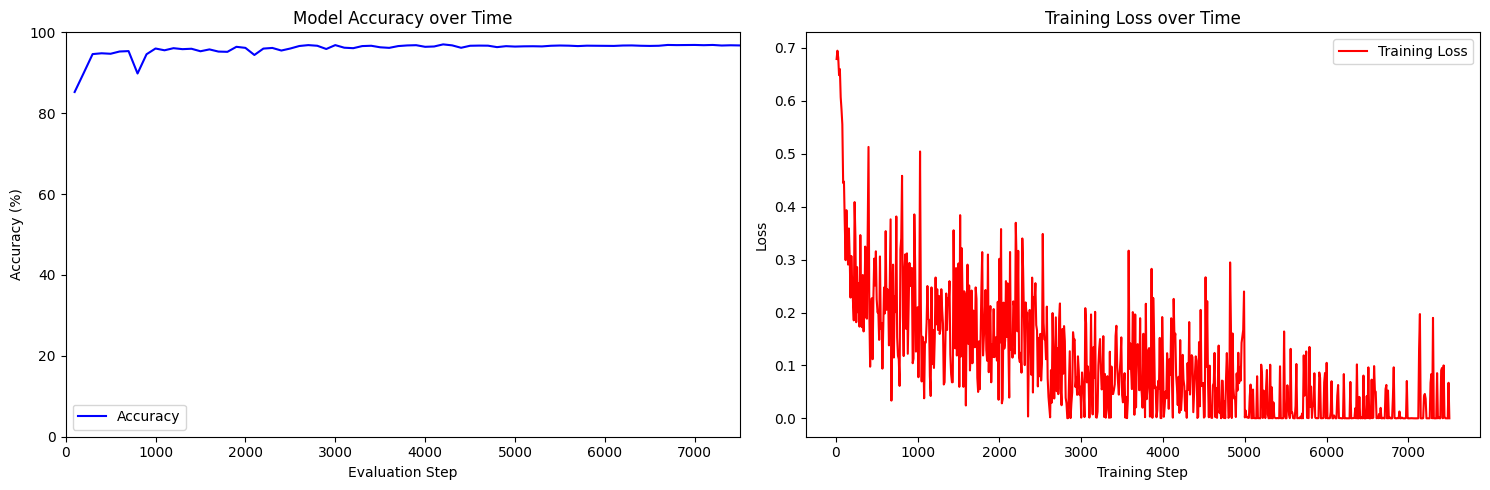

In [17]:
trainer.evaluate()

# Get the training logs that contain evaluation metrics
training_logs = trainer.state.log_history

# Initialize lists to store evaluation steps, accuracy values, and training loss
eval_steps = []
accuracy_vals = []
train_steps = []
train_loss = []

# Extract evaluation steps, accuracy values, and training loss from the logs
for log in training_logs:
   # Extract evaluation accuracy
   if 'eval_accuracy' in log:
       eval_steps.append(log['step'])
       accuracy_vals.append(log['eval_accuracy'] * 100)

   # Extract training loss
   if 'loss' in log and 'eval_loss' not in log:  # Make sure we're getting training loss, not eval loss
       train_steps.append(log['step'])
       train_loss.append(log['loss'])

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
if eval_steps:
   plt.plot(eval_steps, accuracy_vals, label='Accuracy', color='blue')
   plt.xlabel('Evaluation Step')
   plt.ylabel('Accuracy (%)')
   plt.title('Model Accuracy over Time')
   plt.ylim(0, 100)
   plt.xlim(0, max(eval_steps))
   plt.legend()
else:
   print("No evaluation steps found in logs.")

# Plot training loss
plt.subplot(1, 2, 2)
if train_steps:
   plt.plot(train_steps, train_loss, label='Training Loss', color='red')
   plt.xlabel('Training Step')
   plt.ylabel('Loss')
   plt.title('Training Loss over Time')
   plt.legend()
else:
   print("No training steps found in logs.")

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Save the trained model
model.save_pretrained('./suicide_detection_model')

In [28]:
def predict(text, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Move model to the specified device if not already done
    model.to(device)

    # Tokenize and move input to the same device as the model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run prediction
    with torch.no_grad():  # Add this for inference efficiency
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1)

    # Return prediction
    return "Suicidal" if prediction.item() == 1 else "Non-Suicidal"

# Example usage
try:
    test_text = "I don't think I can do this anymore"
    result = predict(test_text)
    print(result)

    # Important: If you're done with GPU operations, you can free up memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

except RuntimeError as e:
    print(f"Error during prediction: {e}")
    print("Please ensure your model and tokenizer are properly loaded")

Suicidal
